In [1]:
import pickle
from pathlib import Path

import PIL
import PIL.Image
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Задание 1
## Загрузка данных

In [2]:
def load_dataset(dataset_path, filename):
    x, y = [], []

    for class_folder in dataset_path.iterdir():
        if class_folder.is_dir():
            for f in class_folder.iterdir():
                if f.is_file() and f.suffix.lower() == ".png":
                    try:
                        img = PIL.Image.open(f).convert('L')
                    except PIL.UnidentifiedImageError:
                        continue
                    img_array = np.array(img).flatten()
                    img_array = img_array / 255.0

                    x.append(img_array)
                    y.append(class_folder.name)

    x = np.array(x)
    y = np.array(y)

    with open(f'{filename}.pickle', 'wb') as f:
        pickle.dump((x, y), f)
    return x, y

In [3]:
def load_pickle(file_name):
    with open(f'{file_name}.pickle', 'rb') as f:
        x, y = pickle.load(f)
    return x, y

load_dataset из разархированной папки с датасетом считывает изображения и для дальнейшей более быстрой загрузки сохраняется в pickle файл

В данной работе в качестве тестовой выборки используется notMNIST_small

In [4]:
load_dataset(Path("/home/user/Education/ML/lab1/notMNIST_large"), "large")
load_dataset(Path("/home/user/Education/ML/lab1/notMNIST_small"), "small")

(array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.29803922, 0.        ,
         0.01568627],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.00392157, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.72941176, 1.        , 0.99607843, ..., 0.03137255, 0.        ,
         0.00392157],
        [0.        , 0.00392157, 0.14509804, ..., 0.        , 0.        ,
         0.        ]]),
 array(['G', 'G', 'G', ..., 'D', 'D', 'D'], dtype='<U1'))

In [5]:
x_test, y_test = load_pickle("small")

In [6]:
x, y = load_pickle("large")

## Загрузка случайных изображений

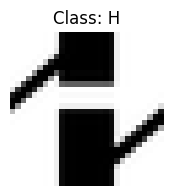

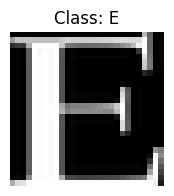

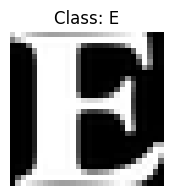

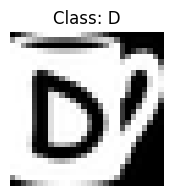

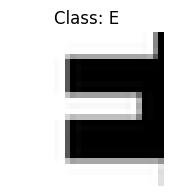

In [7]:
import random

for i in range(5):
    random_index = random.choice(range(len(x)))
    random_image = x[random_index]
    label = y[random_index]
    
    image_size = int(np.sqrt(random_image.size))  # предполагаем квадратное изображение
    reshaped_image = random_image.reshape((image_size, image_size))

    plt.figure(figsize=(2, 2))
    plt.imshow(reshaped_image, cmap='gray')
    plt.title(f"Class: {label}")
    plt.axis('off')
    plt.show()

# Задание 2
## Проверка сбалансированности

In [8]:
def validate_the_balance(y) -> bool:
    # Считаем количество изображений для каждого класса
    unique_classes, counts = np.unique(y, return_counts=True)

    # Печатаем количество изображений для каждого класса
    for class_name, count in zip(unique_classes, counts):
        print(f"Class {class_name}: {count} images")

    # Вычисляем среднее количество изображений и стандартное отклонение
    mean_count = np.mean(counts)
    std_count = np.std(counts)

    # Проверяем сбалансированность на основе стандартного отклонения
    if std_count / mean_count < 0.1:
        print("Classes are balanced.")
        return True
    else:
        print("Classes are NOT balanced.")
        return False

In [9]:
validate_the_balance(y)

Class A: 52909 images
Class B: 52911 images
Class C: 52912 images
Class D: 52911 images
Class E: 52912 images
Class F: 52912 images
Class G: 52912 images
Class H: 52912 images
Class I: 52912 images
Class J: 52911 images
Classes are balanced.


True

In [10]:
validate_the_balance(y_test)

Class A: 1872 images
Class B: 1873 images
Class C: 1873 images
Class D: 1873 images
Class E: 1873 images
Class F: 1872 images
Class G: 1872 images
Class H: 1872 images
Class I: 1872 images
Class J: 1872 images
Classes are balanced.


True

# Задание 3
## Разбиение выборки

Данные загруженные из notMNIST_large используются для формирования обучающей и валидационной выборки

Данные из notMNIST_small - для тестовой выборки

In [11]:
x_train, x_val, y_train, y_val = train_test_split(
    x,
    y,
    test_size=10000,
    train_size=200000,
    random_state=42,
    stratify=y
)

# Задание 4
## Избавление от дубликатов в обучающей выборке

In [12]:
def remove_duplicates_for_pair(x1, y1, x2, y2):
    # Преобразуем наборы данных в множества для поиска дубликатов
    train_set = set([tuple(x) for x in x1])
    test_set = set([tuple(x) for x in x2])

    # Находим пересечения (дубликаты) между обучающим и тестовым наборами
    duplicates = train_set.intersection(test_set)

    if duplicates:
        print(f"Found {len(duplicates)} duplicates in training set.")

        # Удаляем дубликаты только из обучающего набора
        x_train_filtered = np.array([x for x in x1 if tuple(x) not in duplicates])
        y_train_filtered = np.array([y1[i] for i in range(len(y1)) if tuple(x1[i]) not in duplicates])

        # Тестовый набор остается неизменным
        x_test_filtered, y_test_filtered = x2, y2
    else:
        print("No duplicates found.")
        x_train_filtered, y_train_filtered = x1, y1
        x_test_filtered, y_test_filtered = x2, y2

    return x_train_filtered, y_train_filtered, x_test_filtered, y_test_filtered

In [13]:
x_train, y_train, x_test, y_test = remove_duplicates_for_pair(
    x_train, y_train, x_test, y_test
)
x_train, y_train, x_val, y_val = remove_duplicates_for_pair(
    x_train, y_train, x_val, y_val
)

Found 2125 duplicates in training set.
Found 969 duplicates in training set.


# Задание 5
## Построение классификатора с помощью логистической регрессии

In [14]:
def fit_model(x_train, y_train):
    model = LogisticRegression(solver="saga", C=0.01, max_iter=1000)
    model.fit(x_train, y_train)
    accuracy = model.score(x_val, y_val)
    print(f"Validation set accuracy: {accuracy}")
    return model

In [15]:
model = fit_model(x_train, y_train)
y_pred = model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test set accuracy = {accuracy}")

Validation set accuracy: 0.8365
Test set accuracy = 0.8985259559923093


Validation set accuracy: 0.5661
Validation set accuracy: 0.7057
Validation set accuracy: 0.7984
Validation set accuracy: 0.8311


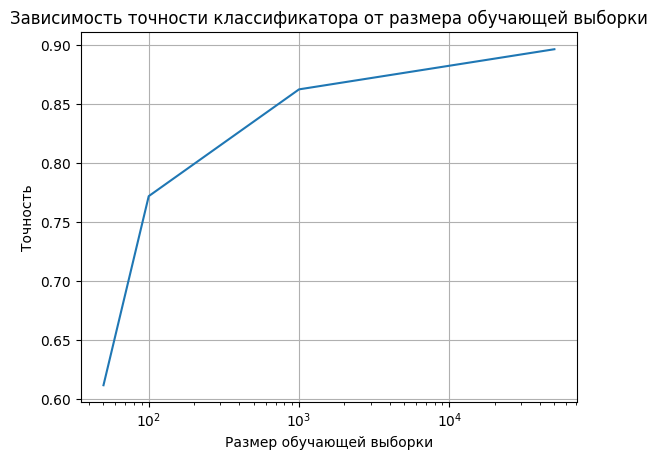

In [16]:
train_sizes = [50, 100, 1000, 50000]
accuracies = []

for train_size in train_sizes:
    x_train, x_val, y_train, y_val = train_test_split(
        x,
        y,
        test_size=10000,
        train_size=train_size,
        random_state=42,
        stratify=y
    )
    model = fit_model(x_train, y_train)
    
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

plt.plot(train_sizes, accuracies)
plt.title("Зависимость точности классификатора от размера обучающей выборки")
plt.xlabel("Размер обучающей выборки")
plt.xscale("log")
plt.ylabel("Точность")
plt.grid()
plt.show()